<center><span style="font-size:3em;color:blue;"><b> Informatique project </p>
</center>

In [1]:
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import year,month,dayofmonth,hour,date_format, to_timestamp
from pyspark.sql.functions import radians, sin, cos, atan2, sqrt
from pyspark.sql.functions import *
import pyspark.sql.functions as F



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

%matplotlib inline

In [2]:
sc = SparkContext()
sqlsc = SQLContext(sc)
spark = sqlsc.sparkSession

# 1. Dataset

## 1.1. Read and transform train set to parquet 

In [3]:
df= sqlsc.read.option('sep',',').option('header','true').option('inferSchema','true').csv('train.csv')

In [4]:
dta = spark.createDataFrame(df.rdd)
dta.write.parquet('train.parquet')

## 1.2. Load data from parquet 

In [5]:
# Import dataset from parquet
df = spark.read.load('train.parquet')
df.show(3)

+-------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|2011-07-24 00:10:00|        5.7|2011-07-24 00:10:...|      -73.981645|      40.743598|       -73.980725|       40.730052|              3|
|2011-08-20 18:03:04|        4.1|2011-08-20 18:03:...|      -73.973492|      40.752369|       -73.966947|        40.76108|              1|
|2012-10-25 10:16:35|        9.5|2012-10-25 10:16:...|       -73.97368|       40.76371|       -73.989415|       40.757887|              1|
+-------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
only showing top 3 rows



In [6]:
# Check type of each variable
df.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: long (nullable = true)



In [7]:
print('There are {} observations in the dataset'.format(df.count()))

There are 55423856 observations in the dataset


## 1.3. Creating new variables

<span style = "font-size:1.5em; color:blue"><b> Converting `pickup_datetime` into datetime type and split datetime

In [8]:
from pyspark.sql.functions import unix_timestamp, from_unixtime

df = df.withColumn('pickup_time', 
                           from_unixtime(unix_timestamp('pickup_datetime','yyyy-MM-dd HH:mm:ss')))

In [9]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, hour

df = df.select('key', 'fare_amount', 'pickup_longitude', 'pickup_latitude', 
              'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_time',
              year('pickup_time').alias('year'),
              month('pickup_time').alias('month'),
              dayofmonth('pickup_time').alias('day_month'),
              dayofweek('pickup_time').alias('day_week'),
              hour('pickup_time').alias('hour')
             )
df.show(3)

+-------------------+-----------+----------------+---------------+-----------------+----------------+---------------+-------------------+----+-----+---------+--------+----+
|                key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|        pickup_time|year|month|day_month|day_week|hour|
+-------------------+-----------+----------------+---------------+-----------------+----------------+---------------+-------------------+----+-----+---------+--------+----+
|2011-07-24 00:10:00|        5.7|      -73.981645|      40.743598|       -73.980725|       40.730052|              3|2011-07-24 00:10:00|2011|    7|       24|       1|   0|
|2011-08-20 18:03:04|        4.1|      -73.973492|      40.752369|       -73.966947|        40.76108|              1|2011-08-20 18:03:04|2011|    8|       20|       7|  18|
|2012-10-25 10:16:35|        9.5|       -73.97368|       40.76371|       -73.989415|       40.757887|              1|2012-10-25 10:16:3

<span style = "font-size:1.5em; color:blue"><b> Compute `distance` taxi traject

In this section, we compute the distance of taxi traject given pickup and dropoff coordinations.
    
- Earth radius in kilometers R = 6371
- $\phi_1$ - radian of `pickup_latitude`
- $\phi_2$ - radian of `dropoff_latitude`
- $\Delta(\phi)$ - radian of `dropoff_latitude` - `pickup_latitude`
- $\lambda_1$ - radian of `pickup_longitude`
- $\lambda_2$ - radian of `dropoff_longitude`
- $\Delta(\lambda)$ - radian of `dropoff_latitude` - `pickup_latitude`

<center>$ a = sin^2(\frac{\Delta(\phi)}{2}) + cos(\phi_1) cos(\phi_2) sin^2(\frac{\Delta(\lambda)}{2})$</center>

<center>Distance = $ 2R.atan2(\sqrt{a}, \sqrt{1-a})$</center>

In [10]:
df = df.withColumn('phi1', radians(col('pickup_latitude')))\
    .withColumn('phi2', radians(col('dropoff_latitude')))\
    .withColumn('d_phi', col('phi2') - col('phi1'))\
    .withColumn('d_lamb', radians(col('dropoff_longitude')) - radians(col('pickup_longitude')))\
    .withColumn('a', (sin(0.5*col('d_phi')))**2 + 
                      cos(col('phi1'))*cos(col('phi2'))*(sin(0.5*col('d_lamb'))**2))\
    .withColumn('distance', 2*6371*atan2(sqrt(col('a')), sqrt(1-col('a'))))

<span style = "font-size:1.5em; color:blue"><b> Variable `weekend`

In [11]:
# Creating new variable of weekend (Saturday and Sunday)
# weekend = 1 if Sunday or Saturday
# weekend = 0 if others
df = df.withColumn('weekend', F.when(col('day_week') == 1 | 7, 1).otherwise(0))


<span style = "font-size:1.5em; color:blue"><b> Variable `rush_hour`

In [12]:
# Creating new variable of rush_hour
# rush_hour = 1 if hours in interval 6-9 and 17-20
# rush_hour = 2 if hours in interval 20-6
# rush_hour = 0 otherwise

df = df.withColumn('rush_hour', when((col('hour').between(6,8))|
                                             (col('hour').between(17,19)), 1).\
                           otherwise(when((col('hour').between(0,5))|
                                          (col('hour').between(20,23)), 2).\
                           otherwise(0)))

In [13]:
# Associate the python dataframe with a SQL table
sqlsc.registerDataFrameAsTable(df, 'train')

# 2. Exploratory data analysis (EDA)

## 2.1. Random subset of dataset to do EDA

In [14]:
# Choose randomly about 2% datasets 
sqlsc.sql('SELECT * FROM train WHERE rand(167) <= 0.02').cache().createOrReplaceTempView('sub_train')

In [15]:
# Check again number of rows in sub-dataset.
sqlsc.sql('SELECT COUNT(key) AS number_of_rows FROM sub_train').show()

+--------------+
|number_of_rows|
+--------------+
|       1106668|
+--------------+



In [16]:
# Change SQL table into DataFrame
df_sub = sqlsc.sql("SELECT * FROM sub_train")
print('Number of observations in the random subset:', df_sub.count())

Number of observations in the random subset: 1106668


In [17]:
df_sub.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_month: integer (nullable = true)
 |-- day_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- phi1: double (nullable = true)
 |-- phi2: double (nullable = true)
 |-- d_phi: double (nullable = true)
 |-- d_lamb: double (nullable = true)
 |-- a: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- weekend: integer (nullable = false)
 |-- rush_hour: integer (nullable = false)



## 2.2. Cleaning sub-dataset

<b> Check and drop `Null` in each column in sub-dataset

In [18]:
df_sub.select([count(when(col(c).isNull(), c)).alias(c) for c in df_sub.columns]).show()

+---+-----------+----------------+---------------+-----------------+----------------+---------------+-----------+----+-----+---------+--------+----+----+----+-----+------+---+--------+-------+---------+
|key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_time|year|month|day_month|day_week|hour|phi1|phi2|d_phi|d_lamb|  a|distance|weekend|rush_hour|
+---+-----------+----------------+---------------+-----------------+----------------+---------------+-----------+----+-----+---------+--------+----+----+----+-----+------+---+--------+-------+---------+
|  0|          0|               0|              0|                3|               3|              0|          0|   0|    0|        0|       0|   0|   0|   3|    3|     3|  3|       3|      0|        0|
+---+-----------+----------------+---------------+-----------------+----------------+---------------+-----------+----+-----+---------+--------+----+----+----+-----+------+---+--------+----

While number of observations with `Null` or missing values in the sub dataset is negligeable small (in both columns of dropoff geographical coordinations), so all observations with missing values will be dropped.

In [19]:
df_sub = df_sub.where((col('dropoff_longitude').isNull() == False) &
                       (col('dropoff_latitude').isNull() == False))
df_sub.count()

1106665

<b> Check and drop negative `fare_amount`

In [20]:
print('Number of observations with negative fare: ',
      df_sub.filter(col('fare_amount') < 0).count())

Number of observations with negative fare:  48


In [21]:
df_sub = df_sub.where((col('fare_amount') > 0))
df_sub.count()

1106587

<span style = "font-size:1.5em; color:blue"><b> Check and drop observations with `passenger_count` over 7.<b></p>
  

In general, we consider all the taxi cars under 8-seats and the number of observations where it's passengers' number is over 7 is negligeable so we decide to drop all these observations.

In [22]:
print('Number of observations where its number of passenger over 7 people is ',
      df_sub.filter(col('passenger_count') > 7).count())

Number of observations where its number of passenger over 7 people is  4


In [23]:
df_sub = df_sub.where((col('passenger_count') < 8))
df_sub.count()

1106583

<span style = "font-size:1.5em; color:blue"> <b> Check and drop observation where `pickup` and `dropoff` geographical coordinations outside New York</b></p>

The geographical coordinations of New York city:

- Latitude ranging from `-90` to `90`
- Longitude ranging from `-180` to `180`

In [24]:
print('Number of observations where pickup latitude outside NY: ',
      df_sub.filter((col('pickup_latitude') < -90) |
                    (col('pickup_latitude') > 90)).count())

Number of observations where pickup latitude outside NY:  27


In [25]:
print('Number of observations where dropoff latitude outside NY: ',
      df_sub.filter((col('dropoff_latitude') < -90) |
                    (col('dropoff_latitude') > 90)).count())

Number of observations where dropoff latitude outside NY:  23


In [26]:
print('Number of observations where pickup longitude outside NY: ',
      df_sub.filter((col('pickup_longitude') < -180) |
                    (col('pickup_longitude') > 180)).count())

Number of observations where pickup longitude outside NY:  30


In [27]:
print('Number of observations where dropoff longitude outside NY: ',
      df_sub.filter((col('dropoff_longitude') < -180) |
                    (col('dropoff_longitude') > 180)).count())

Number of observations where dropoff longitude outside NY:  33


In [28]:
df_sub = df_sub.filter((col('pickup_latitude').between(-90,90)) &
                       (col('dropoff_latitude').between(-90,90)) &
                       (col('pickup_longitude').between(-180,180)) &
                       (col('dropoff_longitude').between(-180,180)))
df_sub.count()

1106519

<span style = "font-size:1.5em; color:blue"><b> Selecting useful variables

In [29]:
cols = ['key', 'fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'month', 'day_month', 'day_week', 
       'hour', 'weekend', 'rush_hour', 'distance']
df_sub = df_sub.select(cols)

In [30]:
cols_desc = ['fare_amount', 'passenger_count', 'distance', 'day_week']
df_sub.select(cols_desc).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|       fare_amount|   passenger_count|          distance|          day_week|
+-------+------------------+------------------+------------------+------------------+
|  count|           1106519|           1106519|           1106519|           1106519|
|   mean|11.342837737083544|1.6853393389539628|19.241446037826726| 4.123364352532582|
| stddev| 10.00164663573272|1.3090547170597784|364.38385336713515|1.9875682406897135|
|    min|              0.01|                 0|               0.0|                 1|
|    max|            2010.9|                 6|13912.815483875987|                 7|
+-------+------------------+------------------+------------------+------------------+



## 2.3. Variables analysis

<span style = "font-size:1.5em; color:blue"><b> Variable `fare_amount`

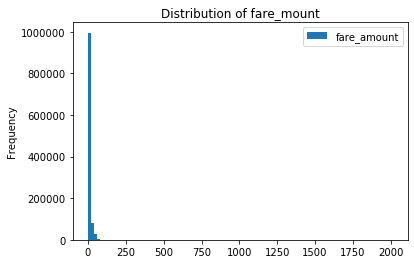

In [31]:
df_sub.select('fare_amount').toPandas().plot.hist(bins = 100,
                                                  title = 'Distribution of fare_mount')

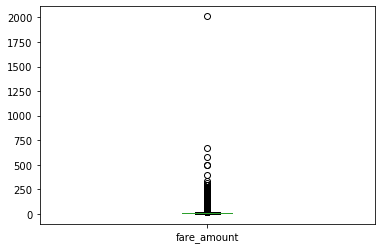

In [32]:
df_sub.select('fare_amount').toPandas().plot.box()

In [33]:
# Check large amount of taxi fare
print('Number of observations with taxi fare superior to 300 is',
      df_sub.filter(col('fare_amount') > 300).count())

Number of observations with taxi fare superior to 300 is 8


In [34]:
print('Number of observations with taxi fare superior to 100 is',
      df_sub.filter(col('fare_amount') > 100).count())

Number of observations with taxi fare superior to 100 is 427


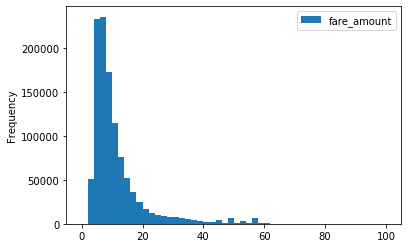

In [35]:
df_sub.filter(col('fare_amount') < 100).select('fare_amount').toPandas().plot.hist(bins = 50)

<b><span style="color:red"> Comment:<b></p>
    
`fare_amount` is very right skewed so, the taxi fare focuses mostly on interval of 0-66 dollars, and all trajects valued more than 100 dollars account for 0.04\% obsevations. 

<span style = "font-size:1.5em; color:blue"><b> Variable `passenger_count`

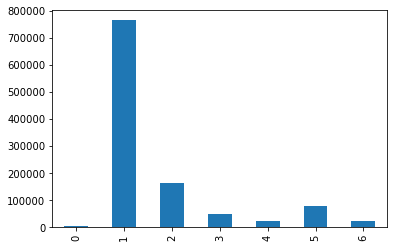

In [36]:
df_sub.select('passenger_count').toPandas()['passenger_count'].value_counts().sort_index().plot.bar()

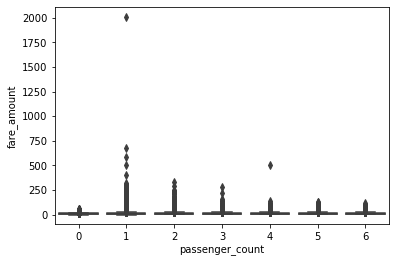

In [37]:
sns.boxplot(x = 'passenger_count', y= 'fare_amount', 
            data = df_sub.select('fare_amount', 'passenger_count').toPandas())

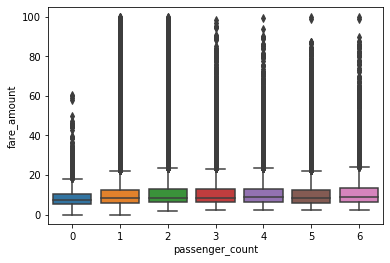

In [38]:
sns.boxplot(x = 'passenger_count', y= 'fare_amount', 
            data = df_sub.filter(col('fare_amount') < 100).select('fare_amount', 
                                                                  'passenger_count').toPandas())

<b><span style="color:red"> Comment:<b></p>
    
Median and 25\%, 75\% quantiles of each type of `passenger_count` seem to be similar.

<span style = "font-size:1.5em; color:blue"><b> Variable `year`

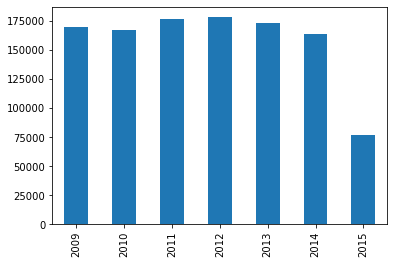

In [39]:
df_sub.select('year').toPandas()['year'].value_counts().sort_index().plot.bar()

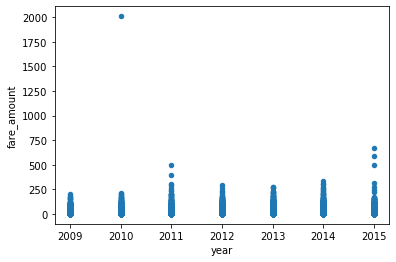

In [40]:
df_sub.select('fare_amount', 'year').toPandas().plot.scatter(x = 'year', y = 'fare_amount')

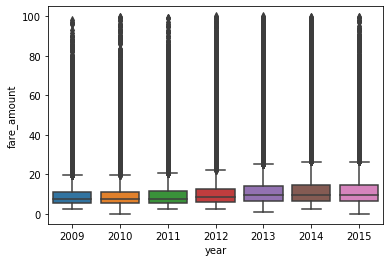

In [41]:
sns.boxplot(x = 'year', y= 'fare_amount',
            data = df_sub.filter(col('fare_amount') < 100).select('fare_amount', 'year').toPandas())

<b><span style="color:red"> Comment:<b></p>

It's obvious that averaged `fare_amount` increases by years.

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


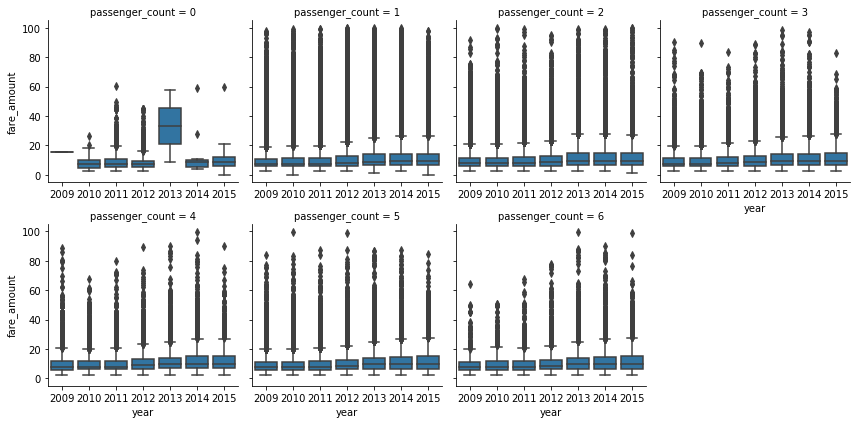

In [42]:
g = sns.FacetGrid(df_sub.filter(col('fare_amount') < 100).\
                  select('fare_amount',
                         'passenger_count',
                         'year').toPandas(),
                  col = 'passenger_count',
                  col_wrap = 4,
                  sharex = False,
                  sharey = True)
g.map(sns.boxplot, 'year', 'fare_amount')

<span style = "font-size:1.5em; color:blue"><b> Variable `month`

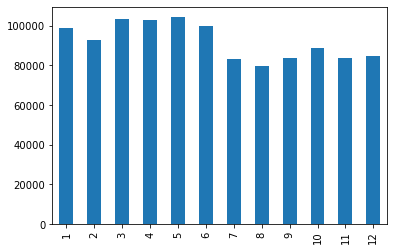

In [43]:
df_sub.select('month').toPandas()['month'].value_counts().sort_index().plot.bar()

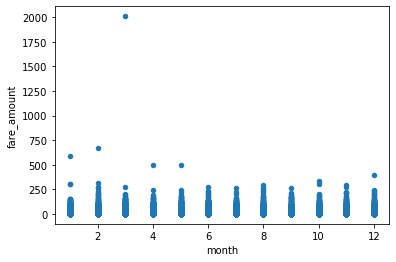

In [44]:
df_sub.select('fare_amount', 'month').toPandas().plot.scatter(x = 'month', y = 'fare_amount')

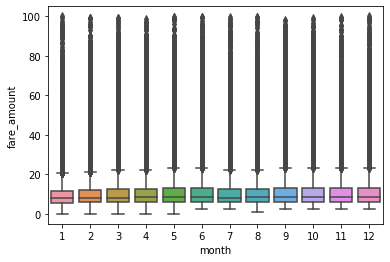

In [45]:
sns.boxplot(x = 'month', y= 'fare_amount',
            data = df_sub.filter(col('fare_amount') < 100).select('fare_amount', 'month').toPandas())

<span style = "font-size:1.5em; color:blue"><b> Variable `day_month`

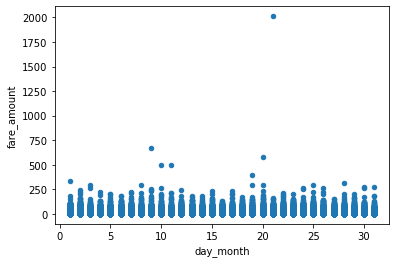

In [46]:
df_sub.select('fare_amount', 'day_month').toPandas().plot.scatter(x = 'day_month', y = 'fare_amount')

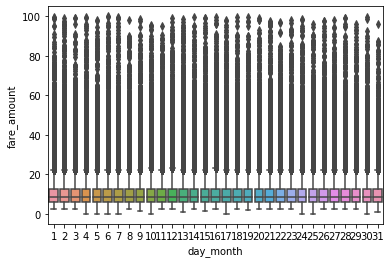

In [47]:
sns.boxplot(x = 'day_month', y= 'fare_amount',
            data = df_sub.filter(col('fare_amount') < 100).\
            select('fare_amount', 'day_month').toPandas())

<span style = "font-size:1.5em; color:blue"><b> Variable `day_week`

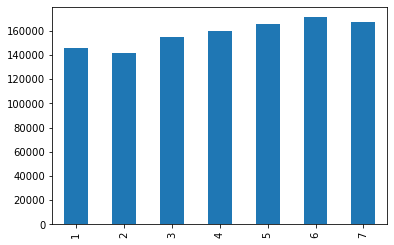

In [48]:
df_sub.select('day_week').toPandas()['day_week'].value_counts().sort_index().plot.bar()

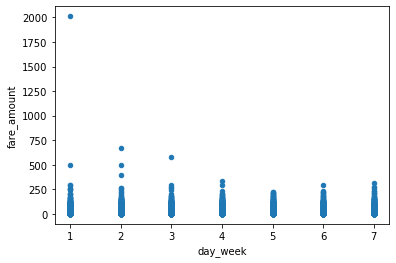

In [49]:
df_sub.select('fare_amount', 'day_week').toPandas().plot.scatter(x = 'day_week', y = 'fare_amount')

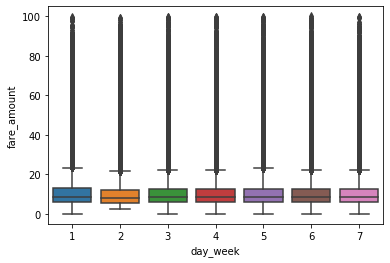

In [50]:
ax = sns.boxplot(x = 'day_week', y= 'fare_amount',
            data = df_sub.filter(col('fare_amount') < 100).\
            select('fare_amount', 'day_week').toPandas())

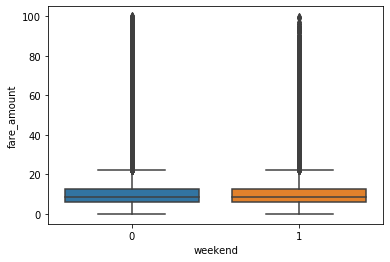

In [51]:
ax = sns.boxplot(x = 'weekend', y= 'fare_amount',
            data = df_sub.filter(col('fare_amount') < 100).\
            select('fare_amount', 'weekend').toPandas())


<span style = "font-size:1.5em; color:blue"><b> Variable `hour`

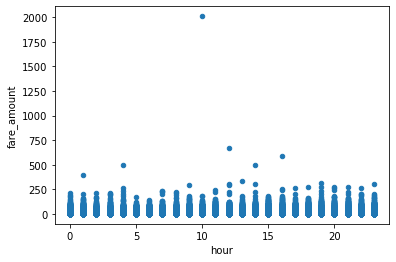

In [52]:
df_sub.select('fare_amount', 'hour').toPandas().plot.scatter(x = 'hour', y = 'fare_amount')

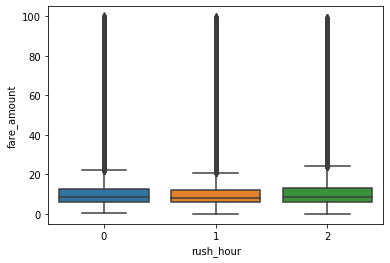

In [53]:
ax = sns.boxplot(x = 'rush_hour', y = 'fare_amount', data = df_sub.filter(col('fare_amount') < 100).\
            select('fare_amount', 'rush_hour').toPandas())

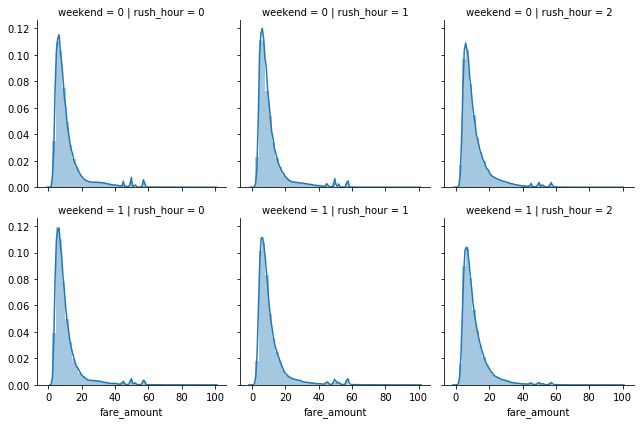

In [54]:
g = sns.FacetGrid(df_sub.filter(col('fare_amount') < 100).\
                  select('fare_amount', 'rush_hour', 'weekend').toPandas(), 
                  col = 'rush_hour', row = 'weekend')
g.map(sns.distplot, 'fare_amount')

<span style = "font-size:1.5em; color:blue"><b> Variable `distance`

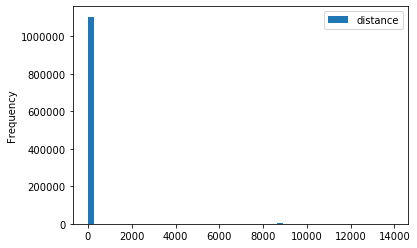

In [55]:
df_sub.select('distance').toPandas().plot.hist(bins = 50)

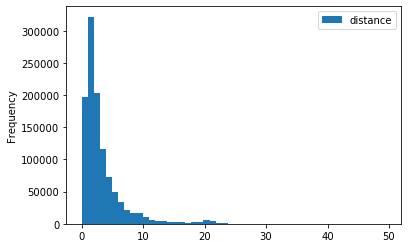

In [56]:
df_sub.filter(col('distance') < 50).select('distance').toPandas().plot.hist(bins = 50)

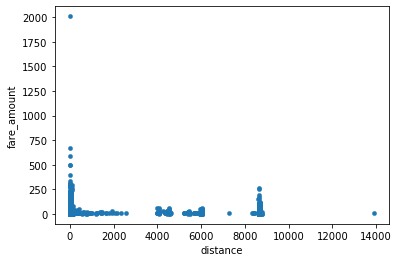

In [57]:
df_sub.select('fare_amount', 'distance').toPandas().\
                plot.scatter(x = 'distance',y = 'fare_amount',linewidths = 0.2, edgecolors = 'face')

In [58]:
# Creating new variable of rush_hour
# distance_bins = 0 if distance in [0-1]
# distance_bins = 1 if distance in [1-10]
# distance_bins = 2 if distance in [10-50]
# distance_bins = 3 if distance > 50

df_sub = df_sub.withColumn('distance_bins', when(col('distance').between(0,1), 0).\
                           otherwise(when(col('distance').between(1,10), 1).\
                                     otherwise(when(col('distance').between(10,50), 2).\
                                               otherwise(3))))

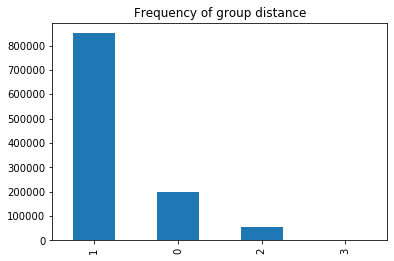

In [59]:
df_sub.select('distance_bins').toPandas()['distance_bins'].\
            value_counts().plot.bar(title='Frequency of group distance')

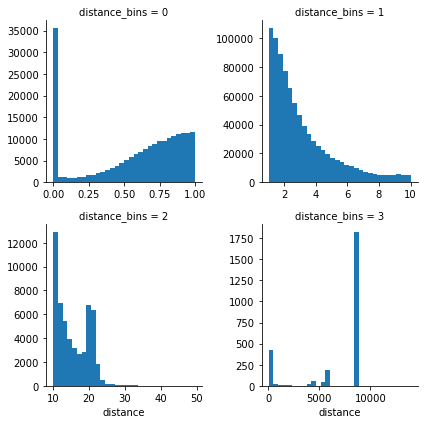

In [60]:
g = sns.FacetGrid(df_sub.select('distance','distance_bins').toPandas(), 
                  col = 'distance_bins', col_wrap = 2, sharex = False, sharey = False)
g.map(plt.hist, 'distance', bins = 30) 

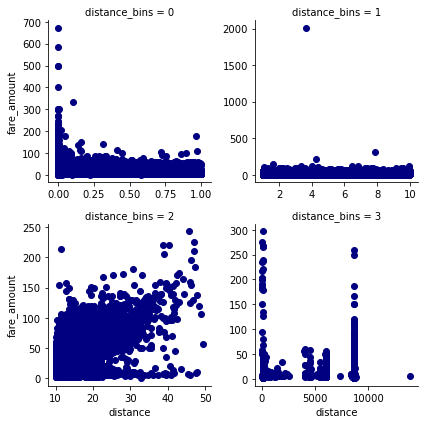

In [61]:
g = sns.FacetGrid(df_sub.select('fare_amount','distance','distance_bins').toPandas(),
                  col = 'distance_bins', col_wrap = 2, sharex = False, sharey = False)
g.map(plt.scatter, 'distance', 'fare_amount', color = 'navy') 

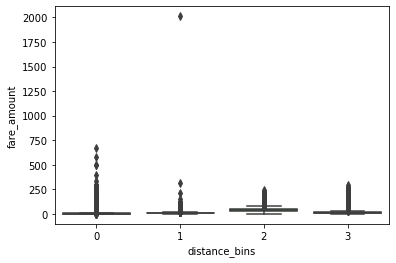

In [62]:
sns.boxplot(x = 'distance_bins', y = 'fare_amount', 
            data = df_sub.select('fare_amount','distance_bins').toPandas())

<span style = "font-size:1.2em; color:red"><b> Taxi fare in New York city information:


(Source: https://www.taxi-calculator.com/taxi-rate-new-york-city/259)
- From Monday to Friday (6:00 am - 20:00 pm): 
    - Base fare 2.5 USD, 
    - Kilometer price 1.56USD/km
    - Waiting time: 30 USD/h
- From Monday to Friday (20:00 pm - 06:00 am) and Week-end: 
    - Base fare 3.0 USD
    - Kilometer price 1.56 USD/km
    - Waiting time: 30 USD/h.
    
    

# 3. Features engineering

<b> Check number of observations where `distance = 0` and `fare_amount < 2.5` and drop these observations

In [63]:
print('Number of observations where distance is 0 and the fare amount lower than 2.5 USD: ', 
      df_sub.filter((col('distance') == 0) & (col('fare_amount') < 2.5)).count(), 'obs')

Number of observations where distance is 0 and the fare amount lower than 2.5 USD:  4 obs


In [64]:
df_sub = df_sub.filter((col('distance') != 0) | (col('fare_amount') >= 2.5))
print('Number of observation where distance in [0-0.25] km: ', 
      df_sub.filter(col('distance').between(0, 0.25)).count(), 'obs')

Number of observation where distance in [0-0.25] km:  43257 obs


For `distance` in `[0, 0.25]` km and the fare is much large (than expected), we can understand that there are cases that a taxi have to wait clients. We need to impute these distances by formula:

- `distance` = (`fare_amount` - 2.5)/1.56 if on weekday
- `distance` = (`fare_amount` - 3)/1.56 if on weekend or night


In [65]:
df_sub = df_sub.withColumn('modified_distance', 
                           when((col('distance').between(0,0.25)) &
                                (col('weekend') == 0) &
                                (col('rush_hour') != 2), 
                                (col('fare_amount')-2.5)/1.56 + 50*rand()).\
                        otherwise(when((col('distance').between(0,0.25)) &
                                        (col('weekend') == 0) &
                                        (col('rush_hour') == 2), 
                                        (col('fare_amount')-3)/1.56 + 50*rand()).\
                                otherwise(when((col('distance').between(0,0.25)) &
                                               (col('weekend') == 1), 
                                               (col('fare_amount')-3)/1.56 + 50*rand()).\
                                            otherwise(col('distance')))))

<b> Do the same way with observations whose `distance` > 300km

In [66]:
df_sub = df_sub.withColumn('modified_distance', 
                           when((col('distance') > 300) &
                                (col('weekend') == 0) &
                                (col('rush_hour') != 2), 
                                (col('fare_amount')-2.5)/1.56 + 50*rand()).\
                        otherwise(when((col('distance') > 300) &
                                        (col('weekend') == 0) &
                                        (col('rush_hour') == 2), 
                                        (col('fare_amount')-3)/1.56 + 50*rand()).\
                                otherwise(when((col('distance') > 300) &
                                               (col('weekend') == 1), 
                                               (col('fare_amount')-3)/1.56 + 50*rand()).\
                                            otherwise(col('modified_distance')))))

<b> Do the same way with observations whose `fare_amount` = 0

In [67]:
df_sub = df_sub.withColumn('modified_fare', 
                           when((col('fare_amount') == 0) &
                                (col('weekend') == 0) &
                                (col('rush_hour') != 2), 
                                col('modified_distance')*1.56 + 2.5 + 20*rand()).\
                        otherwise(when((col('fare_amount') == 0) &
                                        (col('weekend') == 0) &
                                        (col('rush_hour') == 2), 
                                        col('modified_distance')*1.56 + 3 + 20*rand()).\
                                otherwise(when((col('fare_amount') == 0) &
                                               (col('weekend') == 1), 
                                               col('modified_distance')*1.56 + 3 + 20*rand()).\
                                            otherwise(col('fare_amount')))))

<b> Do the same way with observations whose `fare_amount` > 2000

In [68]:
df_sub = df_sub.withColumn('modified_fare', 
                           when((col('fare_amount') > 2000) &
                                (col('weekend') == 0) &
                                (col('rush_hour') != 2), 
                                col('modified_distance')*1.56 + 2.5 + 20*rand()).\
                        otherwise(when((col('fare_amount') > 2000) &
                                        (col('weekend') == 0) &
                                        (col('rush_hour') == 2), 
                                        col('modified_distance')*1.56 + 3 + 20*rand()).\
                                otherwise(when((col('fare_amount') > 2000) &
                                               (col('weekend') == 1), 
                                               col('modified_distance')*1.56 + 3 + 20*rand()).\
                                            otherwise(col('modified_fare')))))

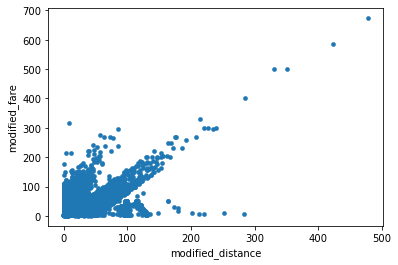

In [69]:
df_sub.select('modified_distance', 'modified_fare').toPandas().\
            plot.scatter(x = 'modified_distance', y = 'modified_fare', 
                         linewidths = 0.2, edgecolors = 'face')

# 4. Training

## 4.1. Model selection

In [70]:
data = df_sub
train, val = data.randomSplit([0.95, 0.05], seed=12345)
print("Number of observations on train set: " + str(train.count()))
print("Number of observations on valid set: " + str(val.count()))

Number of observations on train set: 1051423
Number of observations on valid set: 55092


In [71]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['pickup_longitude', 'pickup_latitude', 
                                       'dropoff_longitude', 'dropoff_latitude', 
                                       'passenger_count', 'year', 'month', 
                                       'day_month', 'day_week', 'weekend', 
                                       'hour', 'rush_hour', 'modified_distance'], outputCol='features')

final_train = assembler.transform(train)
final_val = assembler.transform(val)

## 4.2. Linear Regression

In [72]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol='modified_fare') 
lin_reg = lr.fit(final_train.selectExpr('features','modified_fare')) 

# MSE
print('Linear regression MSE: {:.3f}'.format(lin_reg.summary.rootMeanSquaredError))
# Coefficients
print('Linear regression coefficients: \n', lin_reg.coefficients)

Linear regression MSE: 8.102
Linear regression coefficients: 
 [-0.2863942980480918,-0.24386708108127952,-0.3290041619778365,-0.35454047137981437,0.097802092011117,0.6381058051543742,0.10125550288999983,0.002529479710363178,0.024268638024037194,-0.45180416107588717,-0.006471233827181832,-0.1612098261602754,0.8040596448420002]


<b> Calculating predicted values

In [73]:
train_pred = lin_reg.transform(final_train.selectExpr('features', 'modified_fare'))
val_pred = lin_reg.transform(final_val.selectExpr('features', 'modified_fare'))

<b> Evaluation

In [74]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol= "modified_fare", 
                                metricName="rmse")

In [75]:
print('RMSE on train set: {:.3f}'.format(evaluator.evaluate(train_pred)))
print('RMSE on valid set: {:.3f}'.format(evaluator.evaluate(val_pred)))

RMSE on train set: 8.102
RMSE on valid set: 8.040


## 4.3. Generalized linear regression

In [76]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(family="gaussian", link="identity", 
                                  labelCol='modified_fare', maxIter=10, regParam=0.3)
gl_reg = glr.fit(final_train.selectExpr('features','modified_fare')) 

# Intercept
print('Linear regression intercept: ', gl_reg.intercept)
# Coefficients
print('Linear regression coefficients: \n', gl_reg.coefficients)

Linear regression intercept:  -1258.6376532785669
Linear regression coefficients: 
 [-0.18464347275799403,-0.09101425771344225,-0.18204581369110806,-0.10970987744292984,0.09653198765163551,0.6200315687382627,0.09661059580332357,0.0031961767342416425,0.01948666250559386,-0.42389488514230905,-0.007215616262926863,-0.1434692184231068,0.7612210123406121]


In [77]:
train_pred = gl_reg.transform(final_train.selectExpr('features', 'modified_fare'))
val_pred = gl_reg.transform(final_val.selectExpr('features', 'modified_fare'))

evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol= "modified_fare", 
                                metricName="rmse")

print('RMSE on train set: {:.3f}'.format(evaluator.evaluate(train_pred)))
print('RMSE on valid set: {:.3f}'.format(evaluator.evaluate(val_pred)))

RMSE on train set: 8.118
RMSE on valid set: 8.056


## 4.3. Decision Tree

In [78]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(labelCol="modified_fare", maxDepth=2, varianceCol="variance")
regression = dt.fit(final_train.selectExpr('features','modified_fare')) 

train_pred = regression.transform(final_train.selectExpr('features', 'modified_fare'))
val_pred = regression.transform(final_val.selectExpr('features', 'modified_fare'))

In [79]:
evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol= "modified_fare", 
                                metricName="rmse")
print('RMSE on train set: {:.3f}'.format(evaluator.evaluate(train_pred)))
print('RMSE on valid set: {:.3f}'.format(evaluator.evaluate(val_pred)))

RMSE on train set: 7.215
RMSE on valid set: 6.988


## 4.4. Random forest

In [80]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="modified_fare", maxDepth=5)
regression = rf.fit(final_train.selectExpr('features','modified_fare')) 

train_pred = regression.transform(final_train.selectExpr('features', 'modified_fare'))
val_pred = regression.transform(final_val.selectExpr('features', 'modified_fare'))

In [81]:
evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol= "modified_fare", 
                                metricName="rmse")

In [82]:
print('RMSE on train set: {:.3f}'.format(evaluator.evaluate(train_pred)))
print('RMSE on valid set: {:.3f}'.format(evaluator.evaluate(val_pred)))

RMSE on train set: 5.709
RMSE on valid set: 5.385


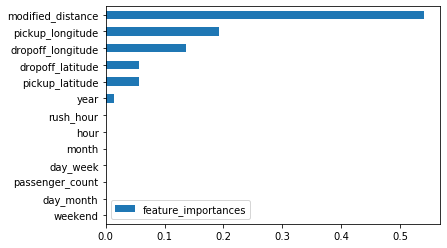

In [83]:
feature_importances = regression.featureImportances
feature_names = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                 'passenger_count', 'year', 'month', 'day_month', 'day_week', 'weekend', 
                 'hour', 'rush_hour', 'modified_distance']
pd.DataFrame(data = list(feature_importances), 
             columns = ['feature_importances'], 
             index = feature_names).sort_values(by = 'feature_importances').plot.barh()

## 4.5. Gradient Boosted tree regression

In [84]:
from pyspark.ml.regression import GBTRegressor

GBt = GBTRegressor(labelCol="modified_fare", maxDepth=5)
regression = GBt.fit(final_train.selectExpr('features','modified_fare')) 

train_pred = regression.transform(final_train.selectExpr('features', 'modified_fare'))
val_pred = regression.transform(final_val.selectExpr('features', 'modified_fare'))

In [85]:
evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol= "modified_fare", 
                                metricName="rmse")

print('RMSE on train set: {:.3f}'.format(evaluator.evaluate(train_pred)))
print('RMSE on valid set: {:.3f}'.format(evaluator.evaluate(val_pred)))

RMSE on train set: 4.675
RMSE on valid set: 4.483
